# 2do

- test if unet wrapper works 
- collect different loss functions to use
- save every xth epoch
- write logs with evaluation scores on test set

In [9]:
import configparser

In [10]:
config = configparser.ConfigParser()
config.read("src/config.ini")

['src/config.ini']

In [12]:
config["Training"]["epochs"]

'100'

In [1]:
import matplotlib.pyplot as plt
import torch 
import PIL
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from torchvision.transforms import ToTensor
PIL.Image.MAX_IMAGE_PIXELS = 933120000
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
from src.u_net import Encoder, Decoder
from src.dataloader import MiceHeartDataset

In [13]:
type((3, 64, 128, 256, 512, 1024))

tuple

In [26]:
(3, 64, 128, 256, 512, 1024)[::-1][:-1]

(1024, 512, 256, 128, 64)

In [3]:
dataset_train = MiceHeartDataset(image_path="data", resolution=512)
dataset_test = MiceHeartDataset(image_path="data", train=False, resolution=512)

['WGA_Phalloidin_NG-24 26 E5 CD45 Merged.tif', 'WGA_Phalloidin_NG-24 26 E6 CD3 Merged.tif', 'WGA_Phalloidin_NG-24 42 E2.tif', 'WGA_Phalloidin_NG-24 42 E3.tif', 'WGA_Phalloidin_NG-24 42 E8.tif', 'WGA_Phalloidin_NG-24 42 E9.tif', 'WGA_Phalloidin_NG-24 43 E10.tif', 'WGA_Phalloidin_NG-24 43 E2.tif', 'WGA_Phalloidin_NG-24 43 E3.tif', 'WGA_Phalloidin_NG-24 43 E4.tif', 'WGA_Phalloidin_NG-24 43 E5 CD45.tif', 'WGA_Phalloidin_NG-24 43 E6 CD3.tif', 'WGA_Phalloidin_NG-24 43 E7 F480.tif', 'WGA_Phalloidin_NG-24 43 E8.tif', 'WGA_Phalloidin_NG-24 43 E9.tif', 'WGA_Phalloidin_NG-24 44 E10.tif', 'WGA_Phalloidin_NG-24 44 E2.tif', 'WGA_Phalloidin_NG-24 44 E3.tif', 'WGA_Phalloidin_NG-24 44 E4.tif', 'WGA_Phalloidin_NG-24 44 E5 CD45.tif', 'WGA_Phalloidin_NG-24 44 E6 CD3.tif', 'WGA_Phalloidin_NG-24 44 E7 F480.tif', 'WGA_Phalloidin_NG-24 44 E8.tif', 'WGA_Phalloidin_NG-24 44 E9.tif', 'WGA_Phalloidin_NG-24 45 E10.tif', 'WGA_Phalloidin_NG-24 45 E2.tif', 'WGA_Phalloidin_NG-24 45 E3.tif', 'WGA_Phalloidin_NG-24 45 E4

In [4]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=2, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=2, drop_last=True)

In [3]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()

In [6]:
import monai
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceLoss(sigmoid=True)

In [7]:
import torch.optim.lr_scheduler as lr_scheduler

In [8]:
loss_fn = torch.nn.BCEWithLogitsLoss().cuda()  # Assuming just 5% positive pixels
epochs = 1
optimizer = torch.optim.Adam(params=[*encoder.parameters(), *decoder.parameters()], lr=0.001)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=0.000005, total_iters=2)
scaler = GradScaler()  # Scale gradients to prevent underflow


In [16]:
len(dataloader_train)

44

In [21]:
inputs.shape[0]

2

In [ ]:
loss_hist_train = []
loss_hist_test = []

for epoch in range(epochs):
    encoder.train()
    decoder.train()
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda().float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        with autocast("cuda"):
            # Make predictions for this batch
            outputs = decoder(encoder(inputs))

            # Compute the loss and its gradients
            loss_value = seg_loss(outputs, labels)

        loss_hist_train.append(loss_value.item())
        print(loss_value.item())

        scaler.scale(loss_value).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # scheduler.step()
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloader_test):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda().float()
            outputs = decoder(encoder(inputs))
            loss_value_test = seg_loss(outputs, labels)
            loss_hist_test.append(loss_value_test.item())

0.9612935781478882
0.9323396682739258
0.9088788032531738
0.8741059899330139
0.860725998878479
0.8508219718933105
0.8886105418205261
0.7913860082626343
0.8919917941093445
0.8035798072814941
0.8962262868881226
0.8642023801803589
0.8287832736968994
0.8572951555252075
0.8354461193084717
0.8143222332000732
0.891536295413971
0.8093451261520386
0.884660542011261
0.8684585690498352
0.8197927474975586
0.8419599533081055
0.8780158758163452
0.9129809141159058
0.8995300531387329
0.8440285921096802
0.8875895738601685
0.8741589784622192
0.746088445186615
0.8368157744407654
0.816008448600769
0.8778723478317261
0.8703242540359497
0.8965491056442261
0.8814982175827026
0.8322543501853943
0.9292855262756348
0.9464332461357117
0.9406496286392212
0.84183269739151
0.9206482172012329
0.8895915150642395
0.8886322975158691
0.8365991115570068


In [10]:
loss_hist_test

[0.8186473846435547,
 0.8094978928565979,
 0.8000317811965942,
 0.7916938066482544]

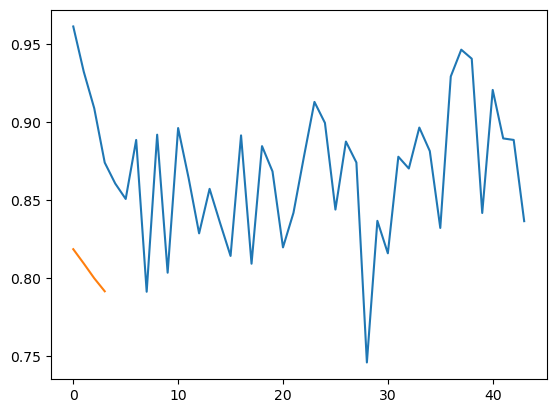

In [11]:
plt.plot(loss_hist_train)
plt.plot(loss_hist_test)

In [12]:
import torch.nn.functional as F

In [13]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_sum = torch.sum(pred_mask) + torch.sum(groundtruth_mask)
    dice = torch.mean(2*intersect/total_sum)
    return dice

def iou(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = torch.mean(intersect/union)
    return iou

tensor(0.0170, device='cuda:0') tensor(0.0086, device='cuda:0')


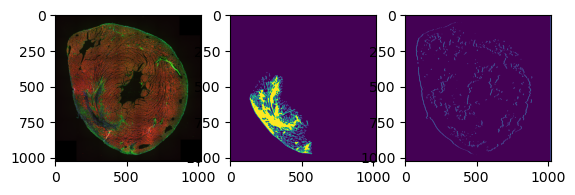

tensor(0.0114, device='cuda:0') tensor(0.0057, device='cuda:0')


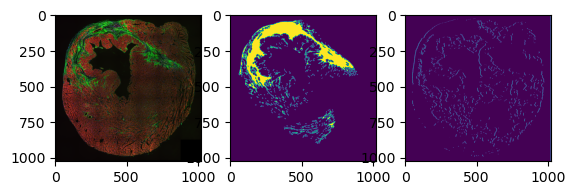

tensor(0.0085, device='cuda:0') tensor(0.0043, device='cuda:0')


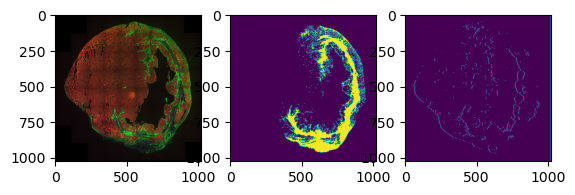

tensor(0.0038, device='cuda:0') tensor(0.0019, device='cuda:0')


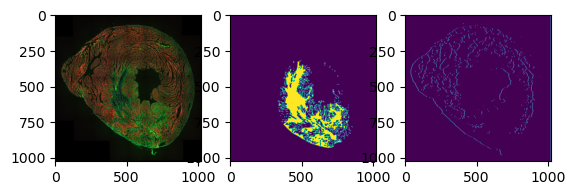

In [14]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    for i, data in enumerate(dataloader_test):
        inputs, labels = data
        labels = labels.cuda().float()
        outputs = F.sigmoid(decoder(encoder(inputs.cuda())))>0.5

        print(dice_coef(labels, outputs), iou(labels, outputs))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(inputs.cpu()[0].permute(1,2,0))
        axarr[1].imshow(labels[0][0].cpu())
        axarr[2].imshow(outputs[0][0].cpu())
        plt.show()

        